IMPORTING LIBRARIES

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:

import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
print(tf.version.VERSION)

2.12.0


In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
epochs=5

LOAD DATASET

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "new_plant_data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2952 files belonging to 3 classes.


In [6]:
valid_set = tf.keras.utils.image_dataset_from_directory(
    'v',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 1426 files belonging to 3 classes.


In [7]:
class_names=dataset.class_names
class_names

['potato_Early_blight', 'potato_healthy', 'potato_late_blight']

In [8]:
len(dataset)

93

DATA VISUALIZATION

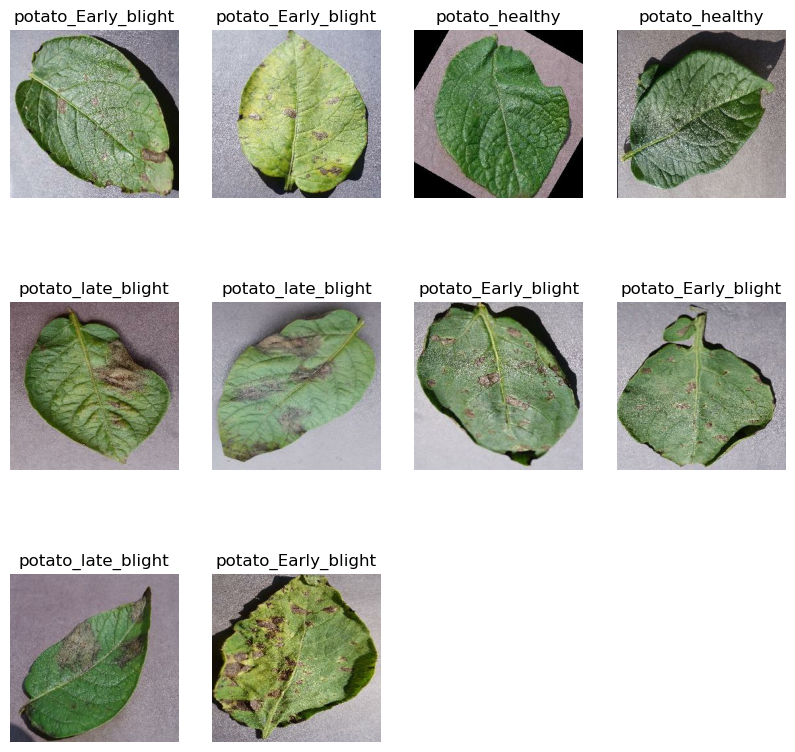

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  #print(image_batch[0].shape)
    
    for i in range(10):
     ax=plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]])
     plt.axis("off")

TRAIN AND TEST DATA DIVISION

In [10]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
     ds_size=len(ds)
     if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
     train_size=int(train_split *ds_size)
     val_size=int(val_split *ds_size)

     train_ds=ds.take(train_size)

     val_ds=ds.skip(train_size).take(val_size)
     test_ds=ds.skip(train_size).skip(val_size)

     return  train_ds,val_ds,test_ds

In [11]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [12]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

74
9
10


DATA PREPROCESSING

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale=tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1.0/255)
    ]
)

In [15]:
data_augmentation=tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2)
    ]
)

BUILDING MODEL

In [16]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential(
    [
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        #layers.Conv2D(128,(3,3),activation='relu'),
        #layers.MaxPooling2D((2,2)),
        #layers.Conv2D(512,(3,3),activation='relu'),
        #layers.MaxPooling2D((2,2)),
        #layers.Conv2D(256,(3,3),activation='relu'),
        #layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(512,activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(n_classes,activation='softmax')


    ]
)
model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                  

MODEL COMPILING AND TRAINING PHASE

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history=model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/50
74/74 [==============================] - 64s 826ms/step - loss: 0.9410 - accuracy: 0.5137 - val_loss: 0.6532 - val_accuracy: 0.6528
Epoch 2/50
74/74 [==============================] - 58s 781ms/step - loss: 0.4477 - accuracy: 0.8387 - val_loss: 0.2277 - val_accuracy: 0.9167
Epoch 3/50
74/74 [==============================] - 56s 759ms/step - loss: 0.2197 - accuracy: 0.9206 - val_loss: 0.3077 - val_accuracy: 0.8785
Epoch 4/50
74/74 [==============================] - 59s 788ms/step - loss: 0.1481 - accuracy: 0.9497 - val_loss: 0.4059 - val_accuracy: 0.8598
Epoch 5/50
74/74 [==============================] - 59s 784ms/step - loss: 0.1132 - accuracy: 0.9595 - val_loss: 0.2949 - val_accuracy: 0.9062
Epoch 6/50
74/74 [==============================] - 58s 778ms/step - loss: 0.0983 - accuracy: 0.9586 - val_loss: 0.1964 - val_accuracy: 0.9444
Epoch 7/50
74/74 [==============================] - 57s 761ms/step - loss: 0.1034 - accuracy: 0.9667 - val_loss: 0.1765 - val_accuracy: 0.9375

### EVALUATING THE MODEL

In [20]:
#TEST SET ACCURACY
scores=model.evaluate(test_ds)
scores

10/10 [==============================] - 2s 171ms/step - loss: 0.1628 - accuracy: 0.9531


[0.1627892702817917, 0.953125]

In [21]:
#VALIDATION SET ACCURACY
scores=model.evaluate(val_ds)
scores

9/9 [==============================] - 2s 174ms/step - loss: 0.2725 - accuracy: 0.9410


[0.2724689841270447, 0.9409722089767456]

SAVING MODEL

In [24]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

with open("model_b26epoch50.tflite",'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpwz2ae_j0/assets


INFO:tensorflow:Assets written to: /tmp/tmpwz2ae_j0/assets


ACCURACY VISUALIZATION

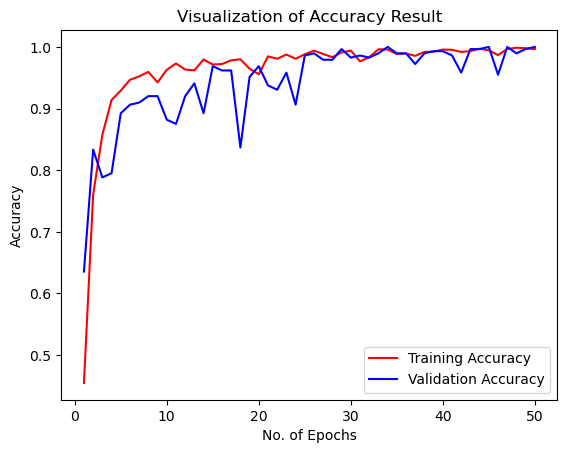

In [30]:
epochs = [i for i in range(1,51)]
plt.plot(epochs,history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

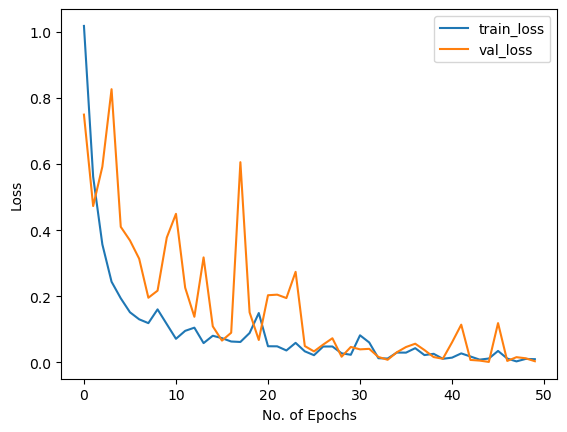

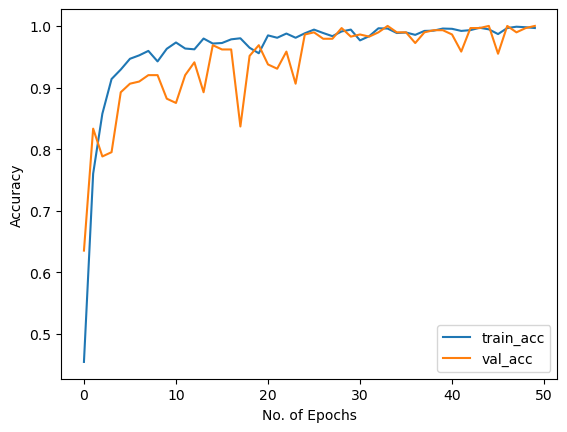

<Figure size 640x480 with 0 Axes>

In [31]:
#Accuracy visualization


plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(history.history['accuracy'],label='train_acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

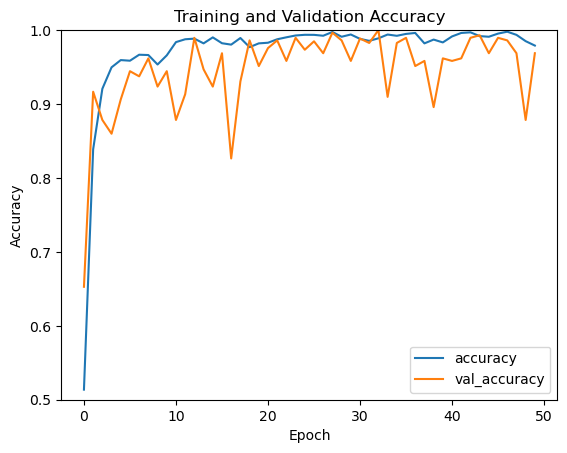

In [49]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

SOME OTHER MATRICS FOR MODEL EVALUATION

In [22]:
test_set = tf.keras.utils.image_dataset_from_directory(
    'v',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 1426 files belonging to 3 classes.


In [23]:
y_pred=model.predict(test_set)
#print(y_pred)
predicted_cat=tf.argmax(y_pred,axis=1)
print(predicted_cat)

1426/1426 [==============================] - 19s 13ms/step
tf.Tensor([0 2 0 ... 2 2 2], shape=(1426,), dtype=int64)


In [24]:
true_cat=tf.concat([y for x,y in test_set ],axis=0)
true_cat
y_true=tf.argmax(true_cat,axis=1)
y_true

<tf.Tensor: shape=(1426,), dtype=int64, numpy=array([0, 0, 0, ..., 2, 2, 2])>

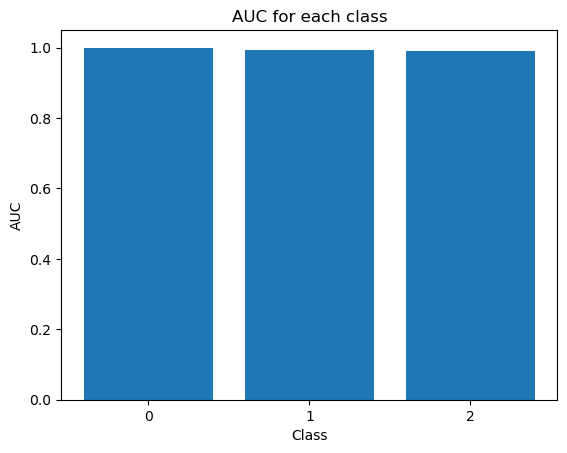

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize


# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Initialize lists to store AUC values for each class
auc_values = []

# Compute AUC for each class
for i in range(y_true_bin.shape[1]):
    auc = roc_auc_score(y_true_bin[:, i], y_pred[:, i])
    auc_values.append(auc)

# Plot AUC values for each class
plt.figure()
plt.bar(range(len(auc_values)), auc_values, align='center')
plt.xticks(range(len(auc_values)), range(len(auc_values)))
plt.xlabel('Class')
plt.ylabel('AUC')
plt.title('AUC for each class')
plt.show()


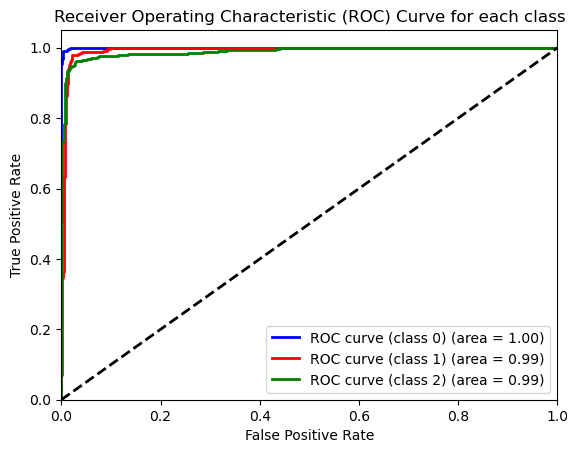

AUC for class 0: 0.999761166558936
AUC for class 1: 0.9926410743353229
AUC for class 2: 0.9897937048763653


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize



# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Initialize lists to store ROC curve data for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(y_true_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred[:, i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']  # Choose colors for the curves
for i, color in zip(range(y_true_bin.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (class {0}) (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
plt.legend(loc="lower right")
plt.show()

# Print AUC scores for each class
for i in range(y_true_bin.shape[1]):
    print(f"AUC for class {i}: {roc_auc[i]}")


In [36]:
#Confusion matrix
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_true,predicted_cat)

In [37]:
# Precision Recall Fscore
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_true,predicted_cat,target_names=class_names))

                     precision    recall  f1-score   support

potato_Early_blight       0.99      0.98      0.99       485
     potato_healthy       0.98      0.76      0.86       456
 potato_late_blight       0.80      0.98      0.88       485

           accuracy                           0.91      1426
          macro avg       0.92      0.91      0.91      1426
       weighted avg       0.92      0.91      0.91      1426



Confusion Matrix Visualization

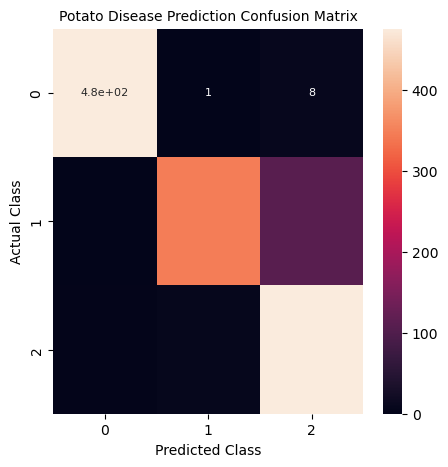

In [48]:
import seaborn as sns
plt.figure(figsize=(5, 5))
sns.heatmap(cm,annot=True,annot_kws={"size": 8})

plt.xlabel('Predicted Class',fontsize = 10)
plt.ylabel('Actual Class',fontsize = 10)
plt.title('Potato Disease Prediction Confusion Matrix',fontsize = 10)
plt.show()

VISUALIZATION OF SOME  PREDICTIONS

first image to predict:
actual label potato_late_blight
1/1 [==============================] - 0s 147ms/step
potato_late_blight


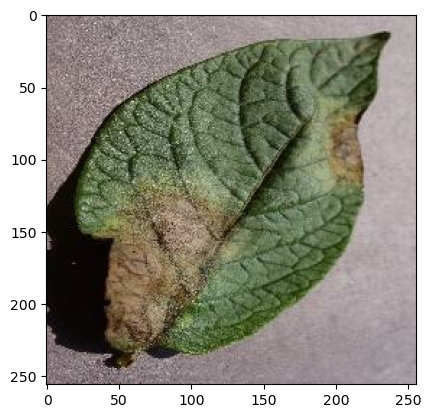

In [33]:
for images_batch, label_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8') 
  first_label=label_batch[0].numpy()

  print("first image to predict:")
  plt.imshow(first_image)
  print("actual label",class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print(class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 32ms/step


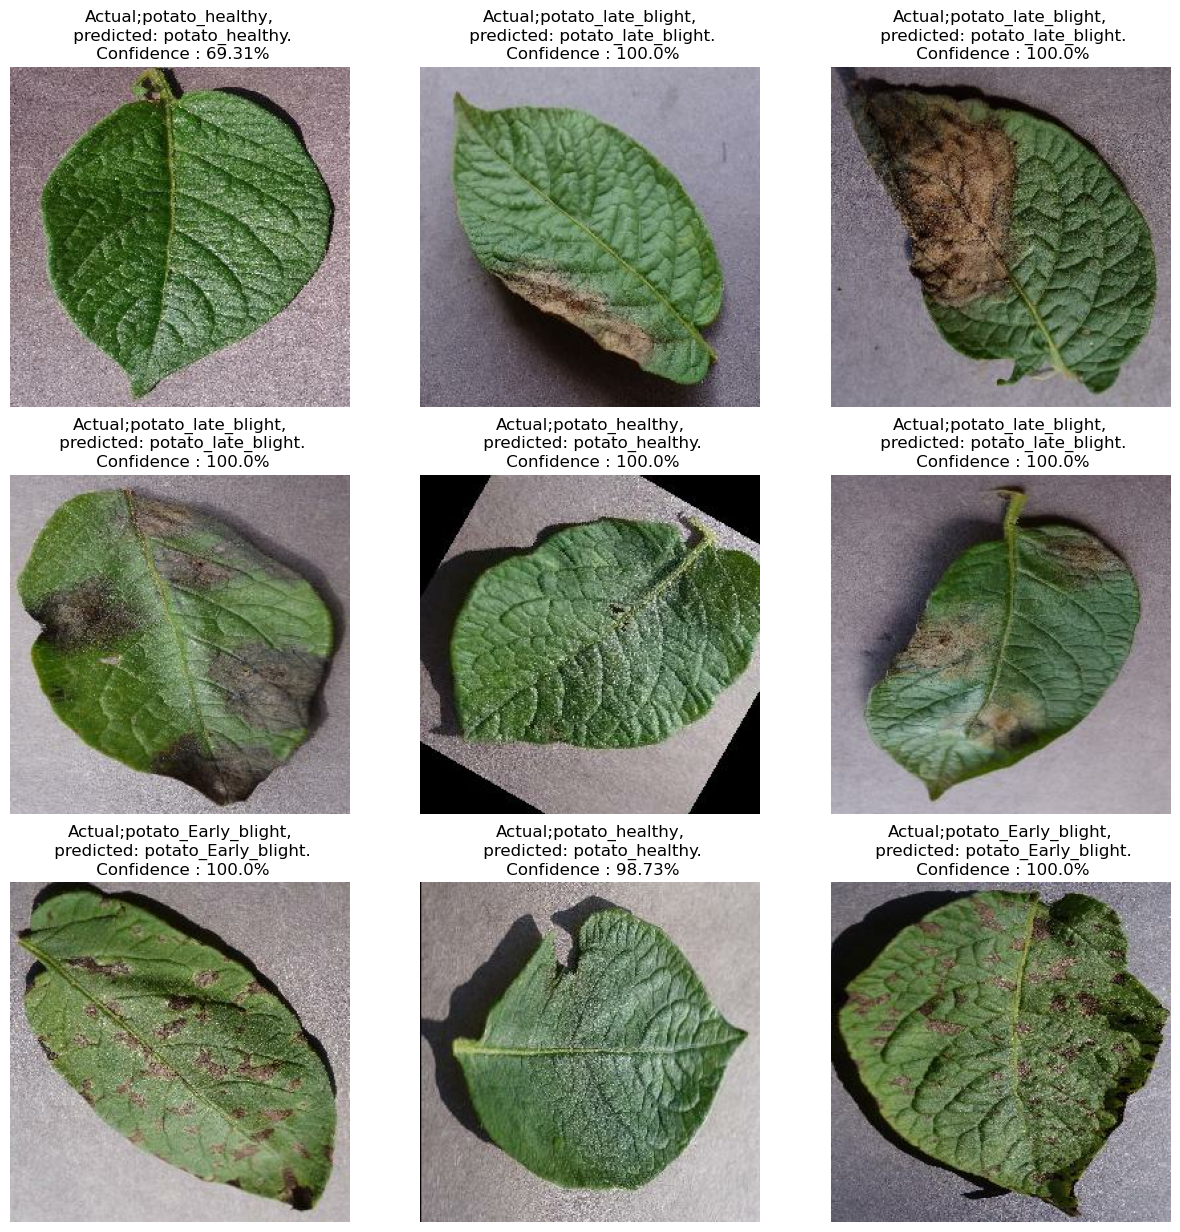

In [67]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual;{actual_class},\n predicted: {predicted_class}.\n Confidence : {confidence}%")
        
        plt.axis("off")